In [1]:

from fim.data.dataloaders import DataLoaderFactory
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
dataset_config = {
    "name": "HawkesDataLoader",
    "path_collections": {
        "train": (
            "/home/berghaus/FoundationModels/FIM/data/synthetic_data/hawkes/rm_me/train",
        ),
        "validation": (
            "/home/berghaus/FoundationModels/FIM/data/synthetic_data/hawkes/rm_me/val",
        )
    },
    "loader_kwargs": {
        "batch_size": 1,
        "num_workers": 8,
        "test_batch_size": 1,
        "variable_num_of_paths": True,
        "min_path_count": 100,
        "max_path_count": 1000,
        "max_number_of_minibatch_sizes": 10,
        "variable_sequence_lens": True,
        "min_sequence_len": 10,
        "max_sequence_len": 250,
        "num_kernel_evaluation_points": 10,
        "is_bulk_model": False
    },
    "dataset_kwargs": {
        "files_to_load": {
            "base_intensities": "base_intensities.pt",
            "event_times": "event_times.pt",
            "event_types": "event_types.pt",
            "kernel_evaluations": "kernel_evaluations.pt",
            "kernel_grids": "kernel_grids.pt"
        }
    }
}

In [3]:
from torch import Tensor
import torch


def normalize_obs_grid(obs_grid: Tensor, seq_lengths: Tensor) -> tuple[Tensor, Tensor]:
        batch_indices = torch.arange(obs_grid.size(0), device=obs_grid.device).view(-1, 1).expand(-1, obs_grid.size(1))
        path_indices = torch.arange(obs_grid.size(1), device=obs_grid.device).view(1, -1).expand(obs_grid.size(0), -1)
        max_times = obs_grid[batch_indices, path_indices, seq_lengths-1]          
        norm_constants = max_times.amax(dim=[1,2])
        obs_grid_normalized = obs_grid / norm_constants.view(-1, 1, 1, 1)
        return obs_grid_normalized

In [4]:
dataloader = DataLoaderFactory.create(**dataset_config)

In [5]:
import torch

num_samples = 10
i = 0

data = []
for sample in dataloader.train_it:
    if i >= num_samples:
        break
    i += 1
    sample["event_times"] = normalize_obs_grid(sample["event_times"], sample["seq_lengths"])
    sample["delta_times"] = sample["event_times"][:, :, 1:] - sample["event_times"][:, :, :-1]
    # Add a delta time of 0 for the first event
    sample["delta_times"] = torch.cat([torch.zeros_like(sample["delta_times"][:, :, :1]), sample["delta_times"]], dim=2)
    data.append(sample)

In [6]:
data[0].keys()

dict_keys(['base_intensities', 'event_times', 'event_types', 'kernel_evaluations', 'kernel_grids', 'seq_lengths', 'delta_times'])

In [7]:
import numpy as np
from datasets import Dataset


def convert_to_easytpp_format(sample):
    # Extract tensors from the dictionary
    event_times = sample["event_times"][0]  # [P, L, 1]
    delta_times = sample["delta_times"][0]  # [P, L, 1]
    event_types = sample["event_types"][0]  # [P, L, 1]
    seq_lengths = sample["seq_lengths"][0]  # [P]

    # Get dimensions
    num_sequences = event_times.shape[0]

    # Initialize list to store the converted data
    easytpp_data = []

    # Process each sequence
    for i in range(num_sequences):
        seq_len = seq_lengths[i].item()

        # Extract valid events for this sequence
        times = event_times[i, :seq_len, 0].cpu().numpy().tolist()
        deltas = delta_times[i, :seq_len, 0].cpu().numpy().tolist()
        types = event_types[i, :seq_len, 0].cpu().numpy().tolist()

        # Create a single sequence entry
        sequence_entry = {
            "time_since_start": times,
            "time_since_last_event": deltas,
            "type_event": types,
            "seq_idx": i,
            "seq_len": seq_len,
            "dim_process": 1
        }
        
        easytpp_data.append(sequence_entry)

    # Create a Hugging Face Dataset
    dataset = Dataset.from_list(easytpp_data)
    return dataset

In [8]:
# Convert each sample to EasyTPP format
converted_datasets = [convert_to_easytpp_format(sample) for sample in data]

# Create the final dataset with the train split
data = [{"test": converted_dataset} for converted_dataset in converted_datasets]

In [9]:
def print_stats(dataset, split='test'):
   dataset = dataset[split]
   stats = {"num_sequences": len(dataset), "max_sequence_length": 0, "min_sequence_length": 1000000, "max_event_time": 0, "min_event_time": 1000000}
   seq_lengths = [len(seq['time_since_last_event']) for seq in dataset]
   times_since_last_event = [time for seq in dataset for time in seq['time_since_last_event']]
   min_delta_event_time = min(times_since_last_event)
   max_delta_event_time = max(times_since_last_event)
   min_seq_length = min(seq_lengths)
   max_seq_length = max(seq_lengths)
   avg_seq_length = sum(seq_lengths) / len(seq_lengths)
   avg_delta_event_time = sum(times_since_last_event) / len(times_since_last_event)
   stats["max_sequence_length"] = max_seq_length
   stats["min_sequence_length"] = min_seq_length
   stats["num_sequences"] = len(seq_lengths)
   stats["avg_sequence_length"] = avg_seq_length
   stats["max_event_time"] = max_delta_event_time
   stats["min_event_time"] = min_delta_event_time
   stats["avg_event_time"] = avg_delta_event_time
   encoutered_marks = set()
   for seq in dataset:
       for mark in seq['type_event']:
           if mark not in encoutered_marks:
               encoutered_marks.add(mark)
   stats["num_marks"] = len(encoutered_marks)
   pprint(stats)

In [10]:
for d in data:
    print_stats(d)

{'avg_event_time': 0.0010039358523439988,
 'avg_sequence_length': 141.79,
 'max_event_time': 0.20779776573181152,
 'max_sequence_length': 149,
 'min_event_time': 0.0,
 'min_sequence_length': 116,
 'num_marks': 5,
 'num_sequences': 100}
{'avg_event_time': 0.0014776044404341561,
 'avg_sequence_length': 101.61578947368422,
 'max_event_time': 0.2632266879081726,
 'max_sequence_length': 158,
 'min_event_time': 0.0,
 'min_sequence_length': 26,
 'num_marks': 5,
 'num_sequences': 190}
{'avg_event_time': 0.0006621240153459051,
 'avg_sequence_length': 136.85714285714286,
 'max_event_time': 0.4461531937122345,
 'max_sequence_length': 232,
 'min_event_time': 0.0,
 'min_sequence_length': 38,
 'num_marks': 5,
 'num_sequences': 280}
{'avg_event_time': 0.004577980871373813,
 'avg_sequence_length': 31.586486486486486,
 'max_event_time': 0.4012533128261566,
 'max_sequence_length': 37,
 'min_event_time': 0.0,
 'min_sequence_length': 26,
 'num_marks': 5,
 'num_sequences': 370}
{'avg_event_time': 0.0005078

In [11]:
def plot_stats(dataset, splits=['train', 'validation', 'test']):
   # Extract the data for each split
   split_data = {split: dataset[split] for split in splits}

   # Create subplots
   fig, axes = plt.subplots(len(splits)+1, 2, figsize=(20, 7*len(splits)))

   for i, split in enumerate(splits):
      data = split_data[split]
      seq_len = data['seq_len']
      time_since_last_event = data['time_since_last_event']


      # Histogram of the seq_len
      axes[i, 0].hist(seq_len, bins=20, edgecolor='k')
      axes[i, 0].set_title(f'Histogram of Sequence Length ({split})')
      axes[i, 0].set_xlabel('Sequence Length')
      axes[i, 0].set_ylabel('Frequency')

      # Histogram of the time_since_last_event
      axes[i, 1].hist(time_since_last_event, bins=20, edgecolor='k')
      axes[i, 1].set_title(f'Histogram of Time Since Last Event ({split})')
      axes[i, 1].set_xlabel('Time Since Last Event')
      axes[i, 1].set_ylabel('Frequency')
      # axes[i, 0].set_xscale('log')

      # axes[i, 0].set_yscale('log')
      # axes[i, 1].set_xscale('log')
      axes[i, 1].set_yscale('log')

   plt.tight_layout()
   plt.show()

In [12]:
def plot_stats_per_event_type(dataset, splits=['train', 'validation', 'test']):
   # Extract the data for each split
   split_data = {split: dataset[split] for split in splits}

   # Create subplots
   num_events = dataset['train'][0]['dim_process']
   fig, axes = plt.subplots(len(splits)*num_events, 2, figsize=(20, 5*len(splits)*num_events))

   for i, split in enumerate(splits):
      data = split_data[split]

      for event_type in range(num_events):
         print(f'Event Type {event_type} for split {split}')
         event_mask = [[d == event_type for d in x['type_event']] for x in data]
         time_since_last_event = [[e for e, m in zip(d['time_since_last_event'], e_m) if m] for d, e_m in zip(data, event_mask)]
         seq_len = [len(x) for x in time_since_last_event]
         # Histogram of the seq_len
         axes[i*num_events + event_type, 0].hist(seq_len, bins=20, edgecolor='k', alpha=0.5, label=f'Event Type {event_type}')
         axes[i*num_events + event_type, 0].set_title(f'Histogram of Sequence Length ({split})')
         axes[i*num_events + event_type, 0].set_xlabel('Sequence Length')
         axes[i*num_events + event_type, 0].set_ylabel('Frequency')

         # Histogram of the time_since_last_event
         axes[i*num_events + event_type, 1].hist(time_since_last_event, bins=20, edgecolor='k', alpha=0.5, label=f'Event Type {event_type}')
         axes[i*num_events + event_type, 1].set_title(f'Histogram of Time Since Last Event ({split})')
         axes[i*num_events + event_type, 1].set_xlabel('Time Since Last Event')
         axes[i*num_events + event_type, 1].set_ylabel('Frequency')

      axes[i*num_events + event_type, 0].legend()
      axes[i*num_events + event_type, 1].legend()
      axes[i*num_events + event_type, 1].set_yscale('log')

   plt.tight_layout()
   plt.show()

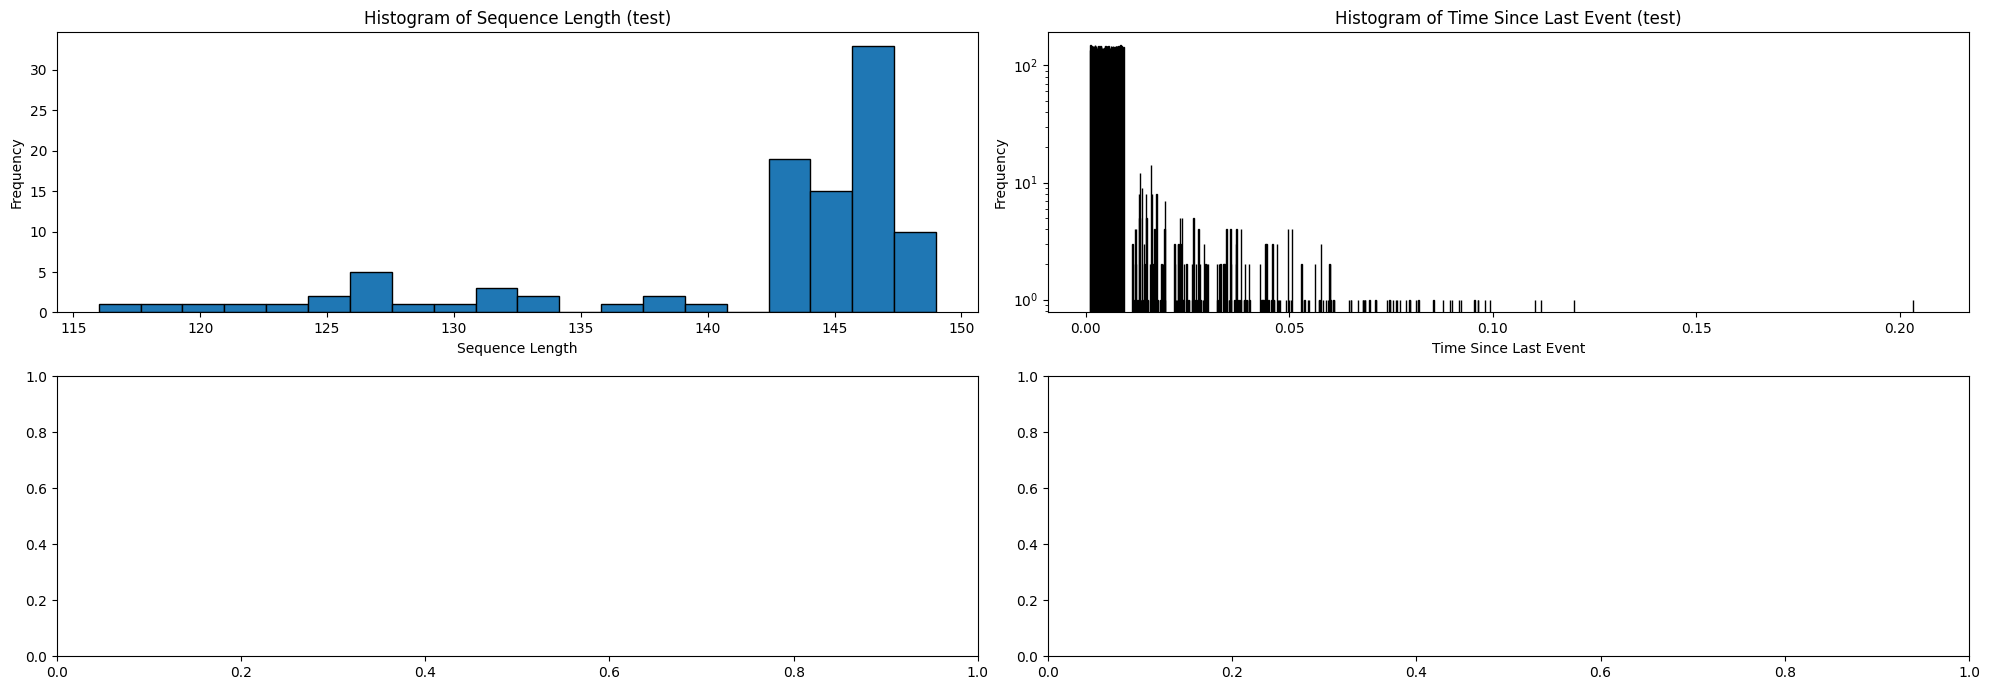

In [13]:
plot_stats(data[0], splits=['test'])

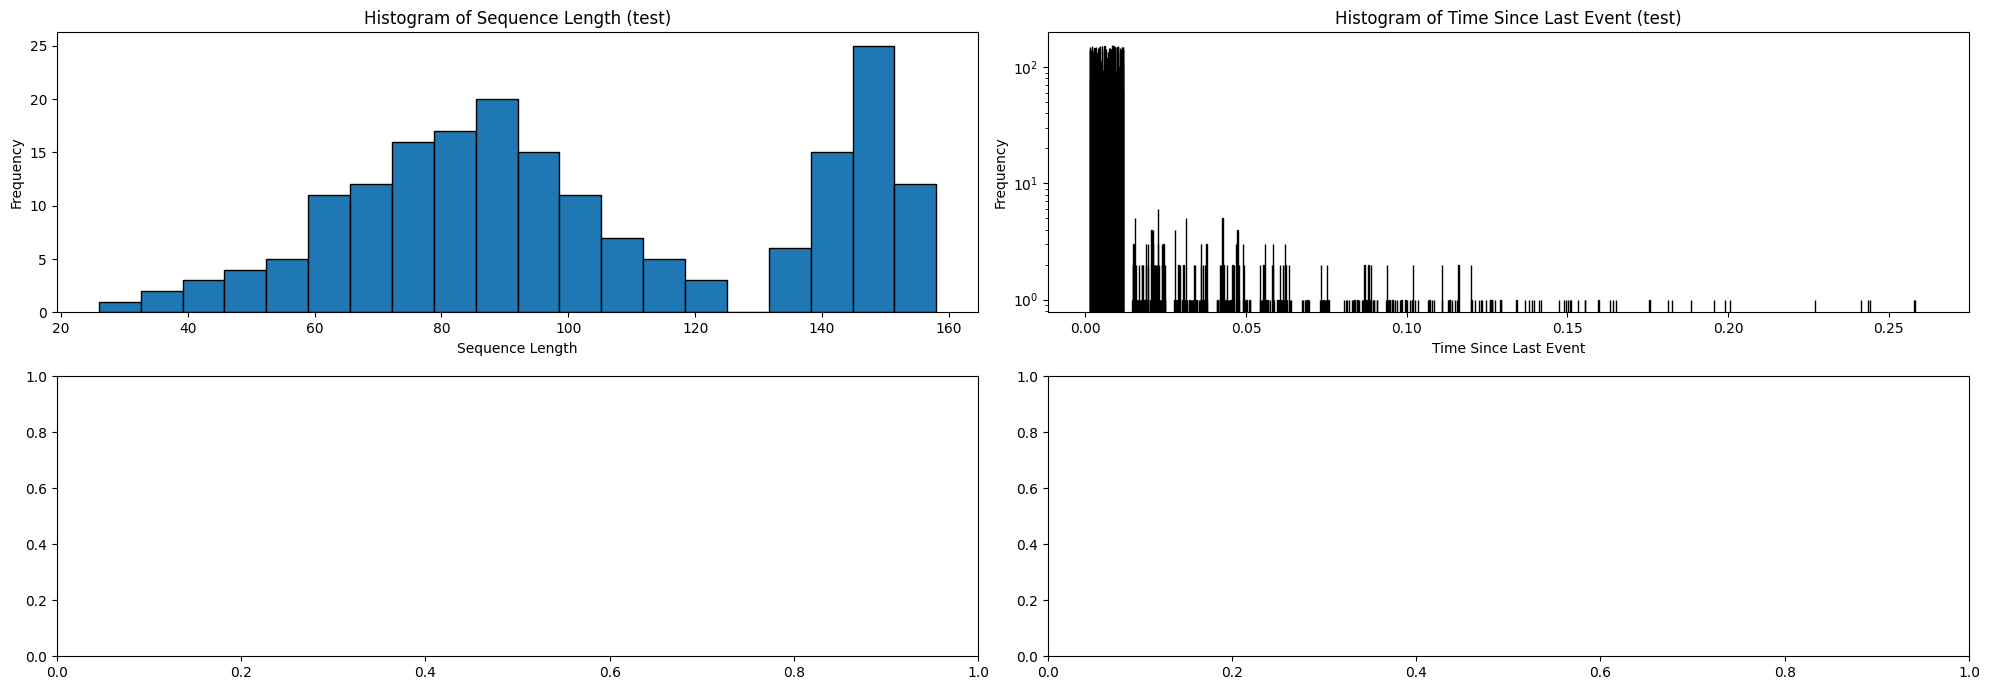

In [14]:
plot_stats(data[1], splits=['test'])

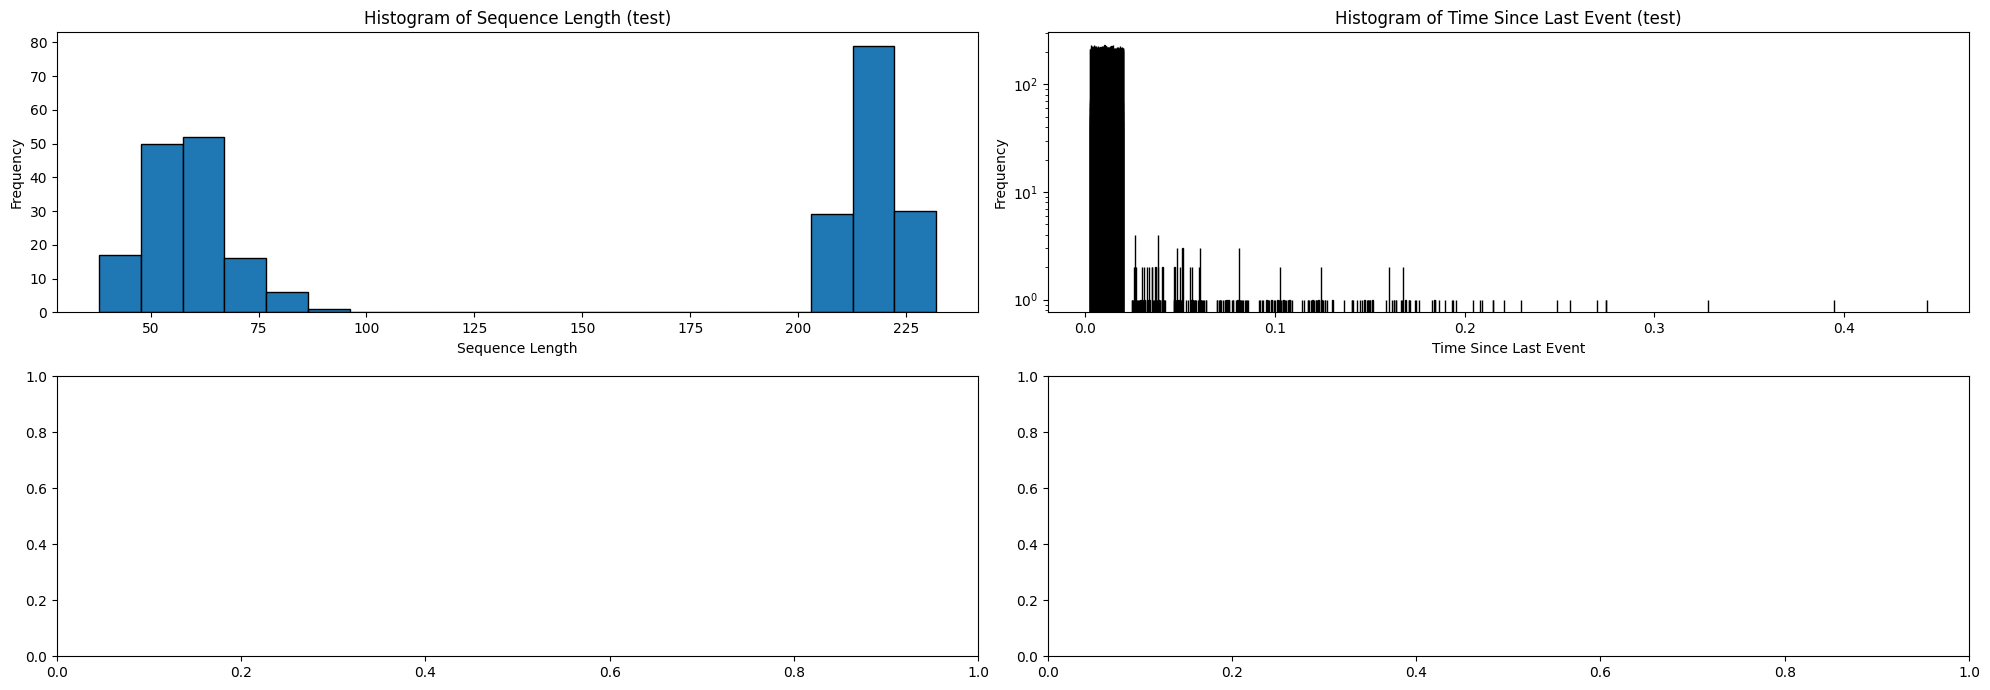

In [15]:
plot_stats(data[2], splits=['test'])

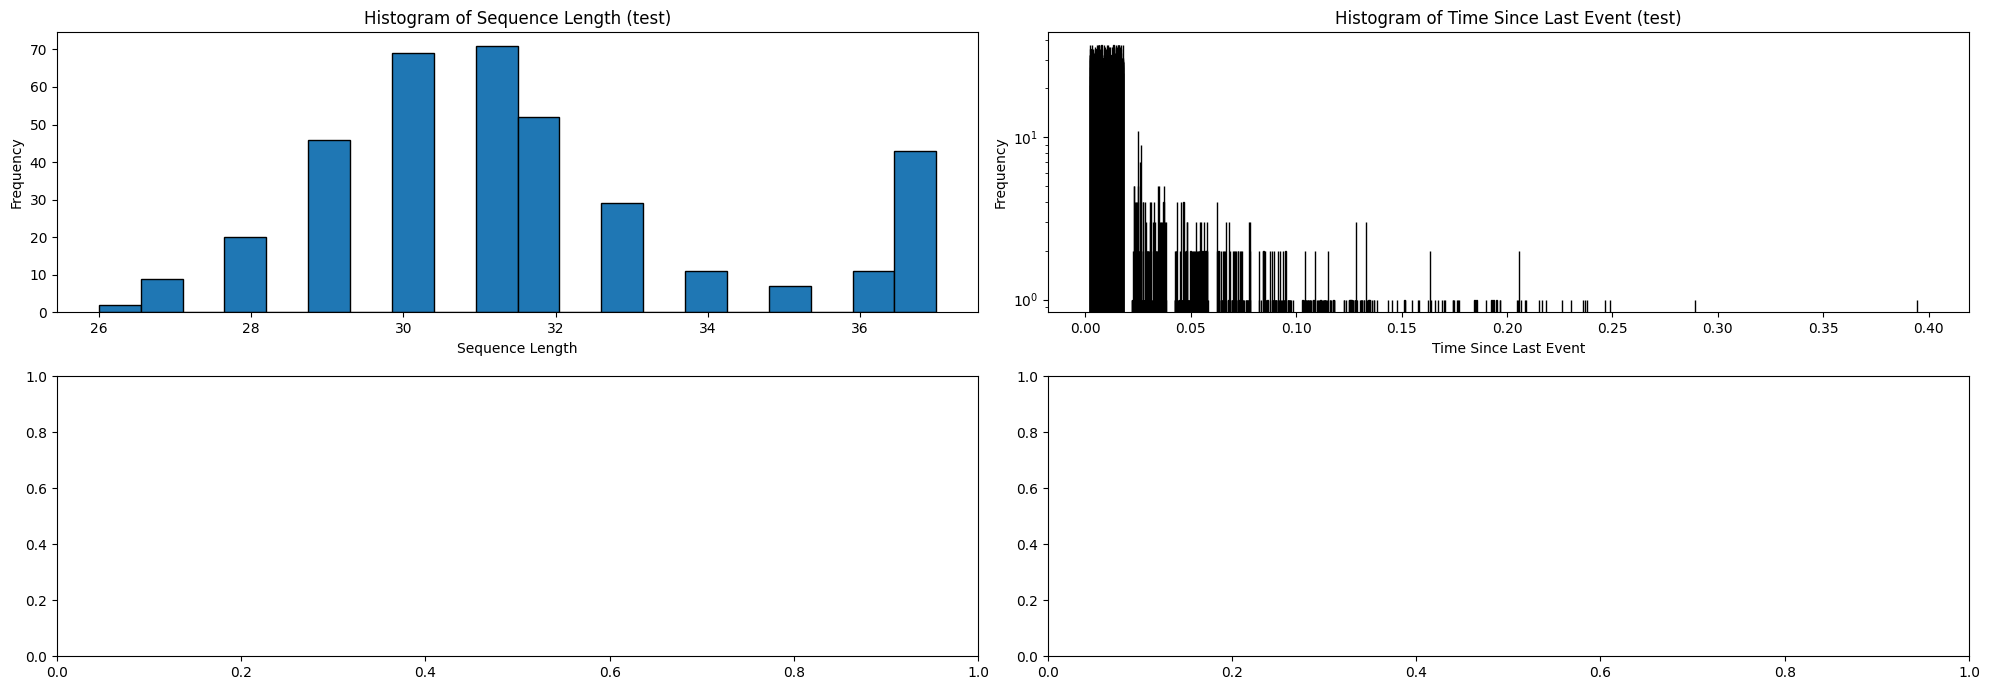

In [16]:
plot_stats(data[3], splits=['test'])

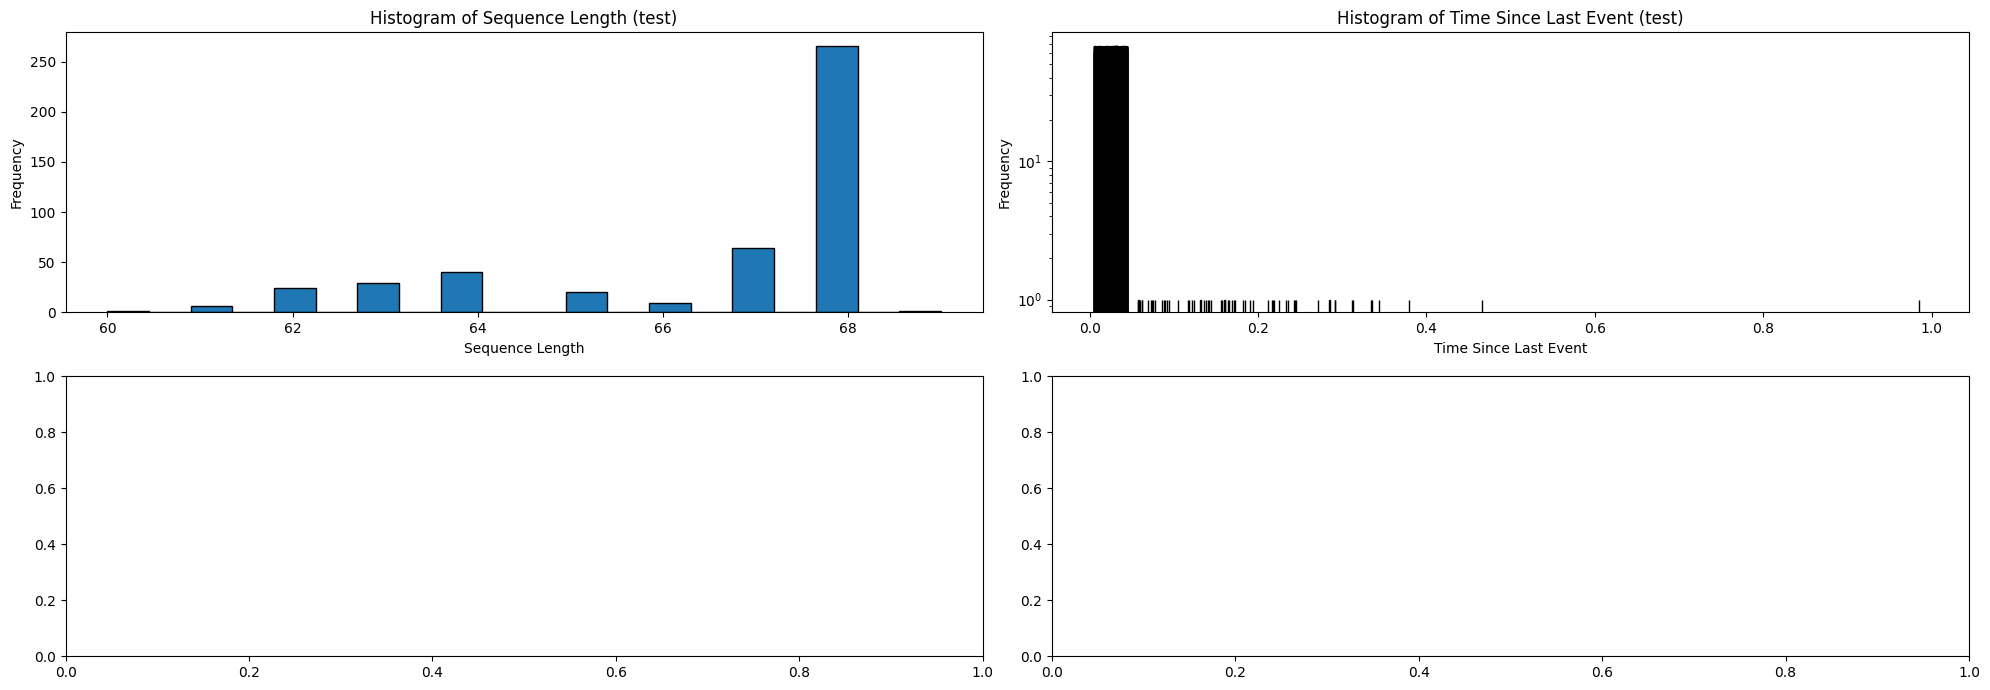

In [17]:
plot_stats(data[4], splits=['test'])

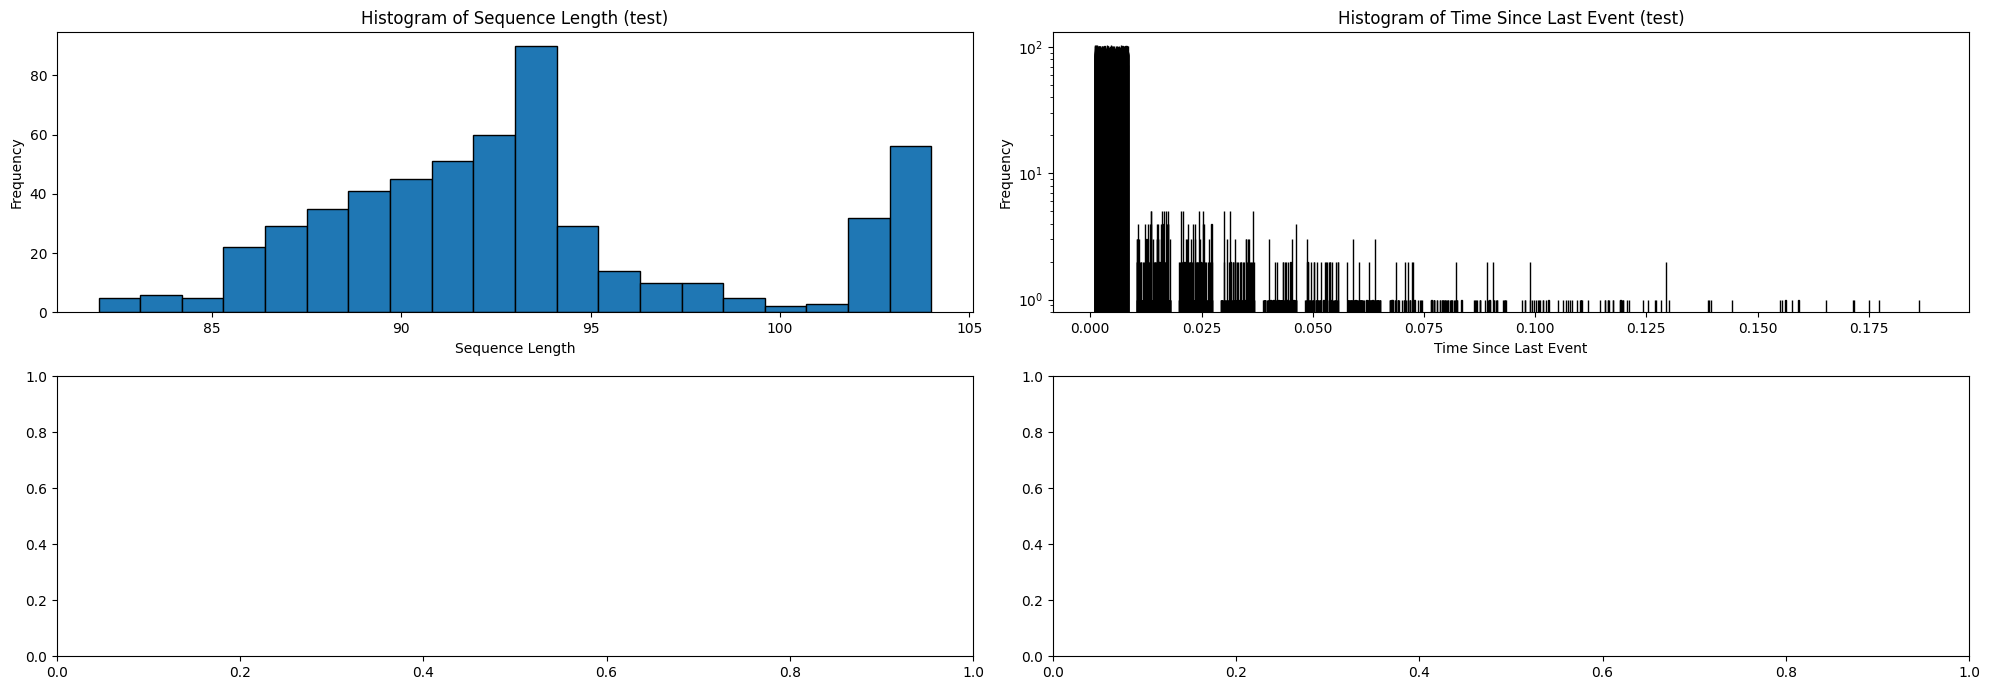

In [18]:
plot_stats(data[5], splits=['test'])

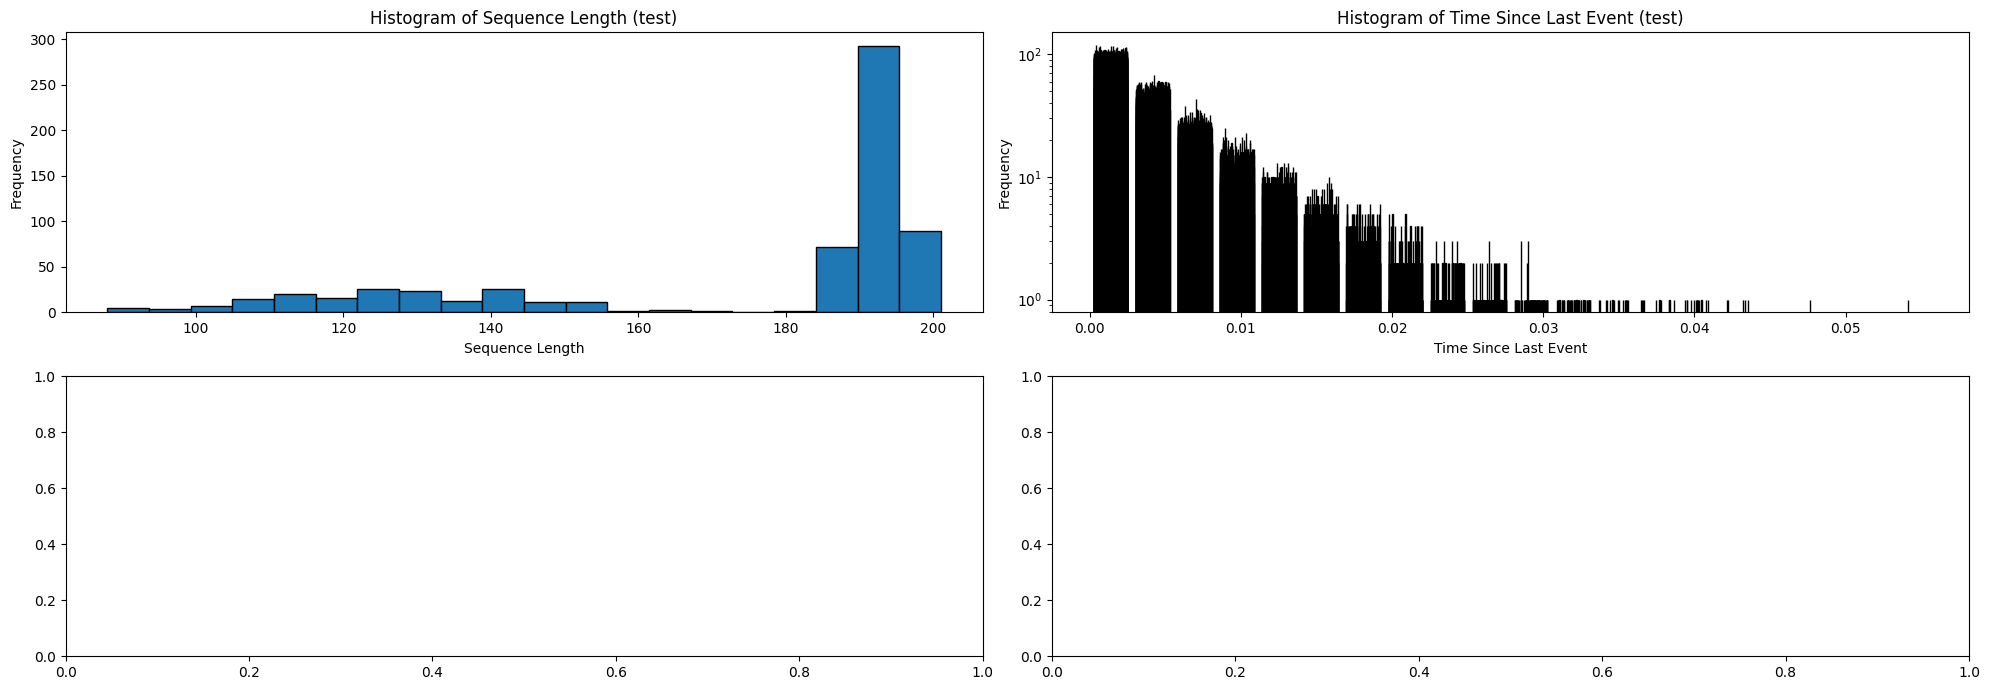

In [19]:
plot_stats(data[6], splits=['test'])

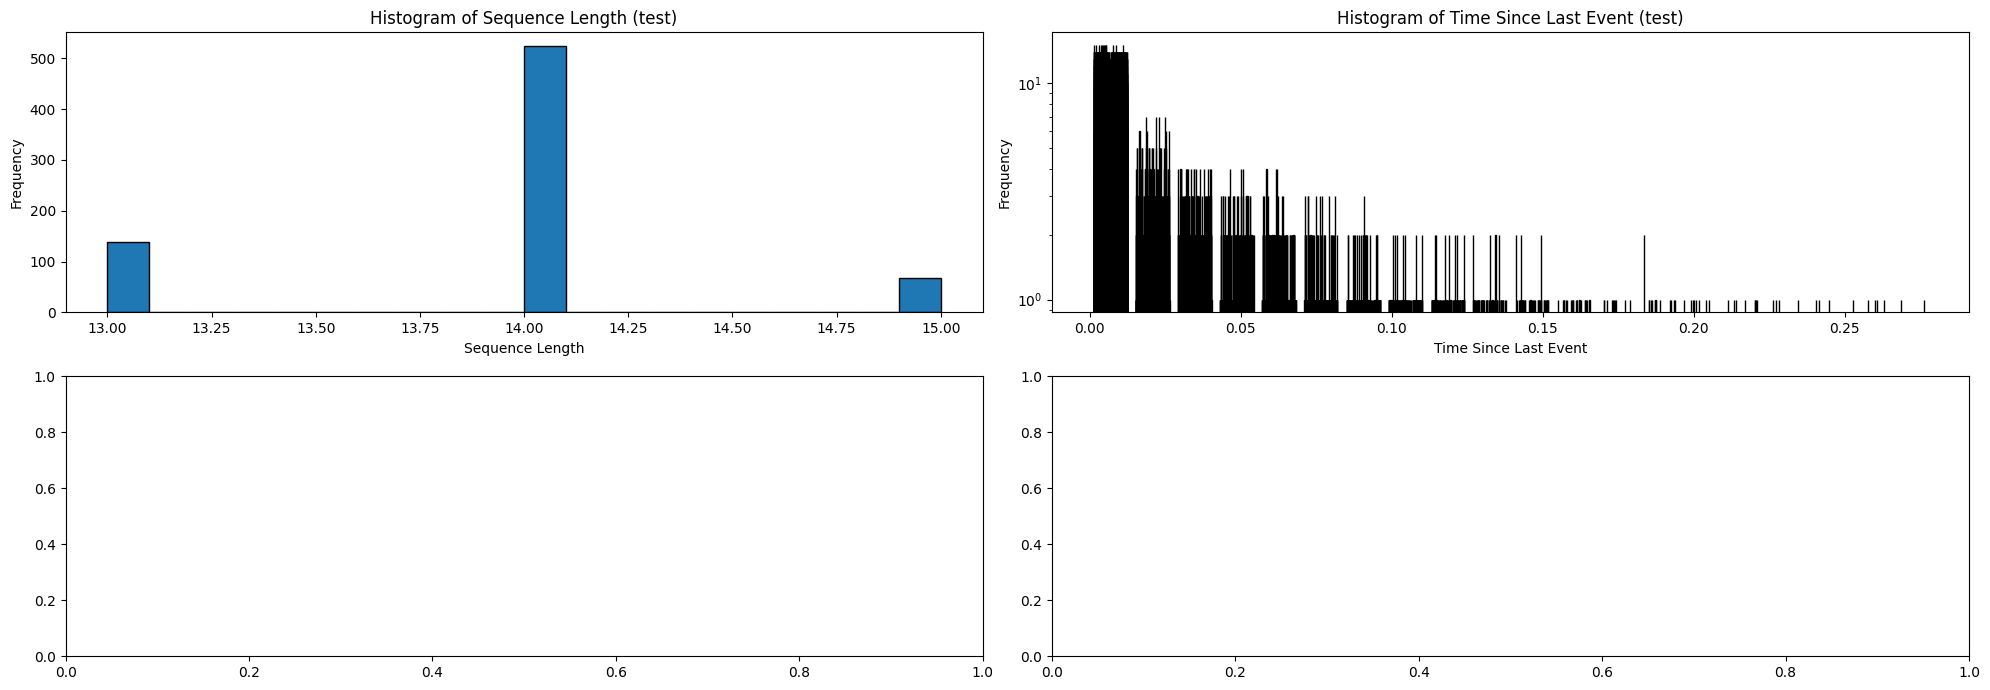

In [20]:
plot_stats(data[7], splits=['test'])